# IMPORTS

In this project, I attempt to understand the features that are closely and losely related to a credit default. The final goal is to build a machine learning model that predicts the likelyhood an individual will default on their credit.


The dataset used is publically available on Kaggle, it has been pre-encoded to make it easy for modelling

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.metrics import precision_score, recall_score, auc, roc_curve, confusion_matrix, classification_report
%matplotlib inline

# DATA PREPROCESSING

## UNDERSTANDING THE DATA

In [2]:
# Load the dataset
df = pd.read_csv("bankloans.csv")
df.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,41,3,17,12,176,9.3,11.359392,5.008608,1.0
1,27,1,10,6,31,17.3,1.362202,4.000798,0.0
2,40,1,15,14,55,5.5,0.856075,2.168925,0.0
3,41,1,15,14,120,2.9,2.658720,0.821280,0.0
4,24,2,2,0,28,17.3,1.787436,3.056564,1.0


In [3]:
df.shape

(1150, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1150 non-null   int64  
 1   ed        1150 non-null   int64  
 2   employ    1150 non-null   int64  
 3   address   1150 non-null   int64  
 4   income    1150 non-null   int64  
 5   debtinc   1150 non-null   float64
 6   creddebt  1150 non-null   float64
 7   othdebt   1150 non-null   float64
 8   default   700 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 81.0 KB


Our dataset contians 1150 rows which represent unique individuals. And 9 features of their credit status. The features have been encoded and are all integers and floating point numbers

## DATA CLEANING 

### HANDLING MISSING VALUES

First, let's look at the number of missing values in each column:

In [5]:
# Check for missing values
print(df.isnull().sum())

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     450
dtype: int64


In [6]:
print(df.isna().sum() / df.shape[0] * 100)

age          0.000000
ed           0.000000
employ       0.000000
address      0.000000
income       0.000000
debtinc      0.000000
creddebt     0.000000
othdebt      0.000000
default     39.130435
dtype: float64


The data has 450 missing value in the default column, which represent 39% of the column.

We have several choices to resolve the issues, such as requiring additional information, infering missing information for another columns, or using the mode to fill out the missing values.

To select the best method, we can further drill down into the descriptive statistics of the column 

In [7]:
df["default"].describe()

count    700.000000
mean       0.261429
std        0.439727
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: default, dtype: float64

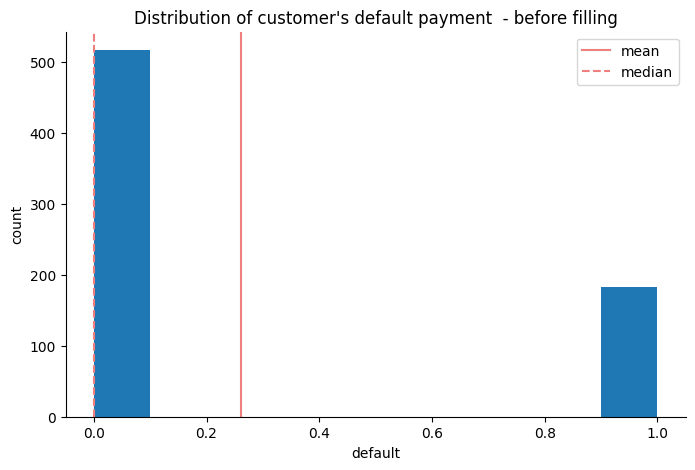

In [8]:
plt.figure(figsize=(8, 5))

plt.hist(df["default"])

plt.axvline(df["default"].mean(), color="lightcoral", label="mean")
plt.axvline(df["default"].median(), color="lightcoral", linestyle="--", label="median")

plt.title("Distribution of customer's default payment  - before filling")
plt.ylabel('count')
plt.xlabel("default")
sns.despine()

plt.legend()
plt.show()

We notice that the column is not over or under sampled, thus filling missing values with a statistic like the mode would be inappropriate.

Our options are thus to predict the missing values based on other columns, or drop them all together. For this project I chose to drop them

In [9]:
# Dropping missing values
df = df.dropna()

Confirm our work

In [10]:
df.isna().sum()

age         0
ed          0
employ      0
address     0
income      0
debtinc     0
creddebt    0
othdebt     0
default     0
dtype: int64

### HANDLING DUPLICATES

In [11]:
# Check for duplicates
print("Number of duplicates:", df.duplicated().sum())

Number of duplicates: 0


In [12]:
df.T.duplicated()

age         False
ed          False
employ      False
address     False
income      False
debtinc     False
creddebt    False
othdebt     False
default     False
dtype: bool

Our dataset has no duplicate rows.
<br>We proceed to the next steps

### HANDLING OUTLIERS

Outliers can have a unwanted effect in our dataset. Such as leading to false conclusions in our analysis and skewing our machine learning models.
<br>As such, it is essential for us to identify them

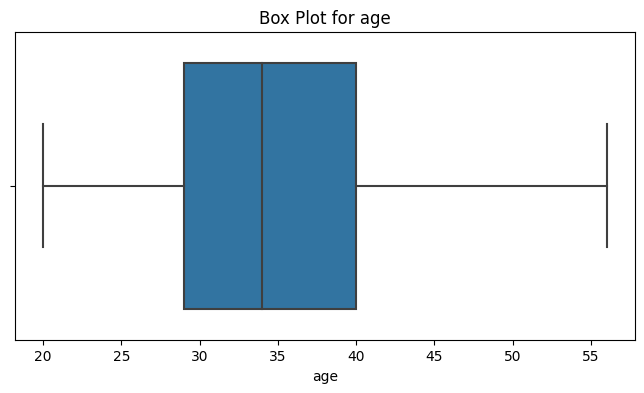

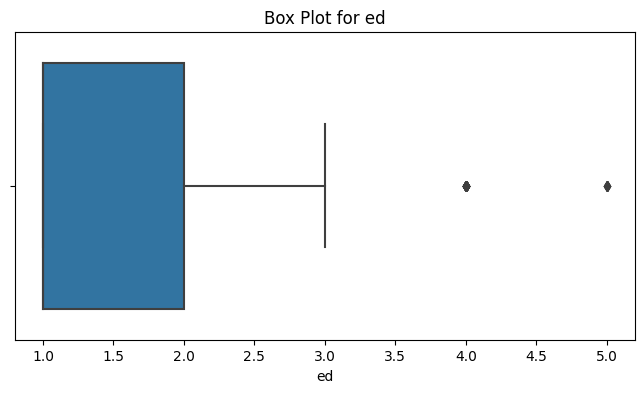

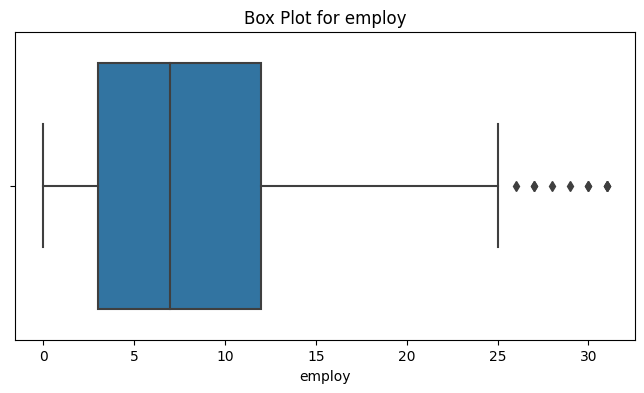

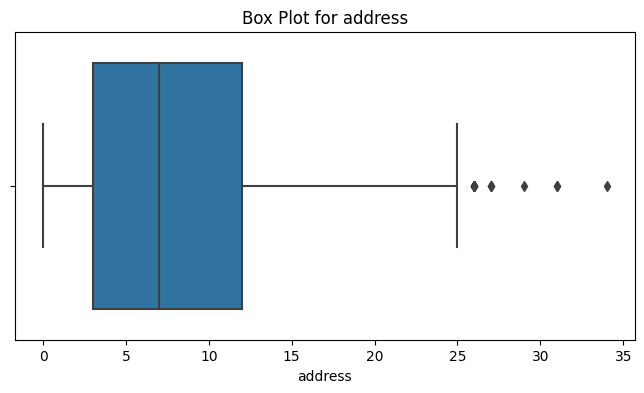

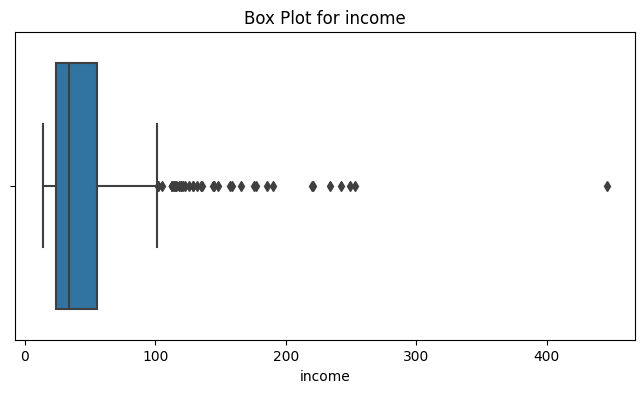

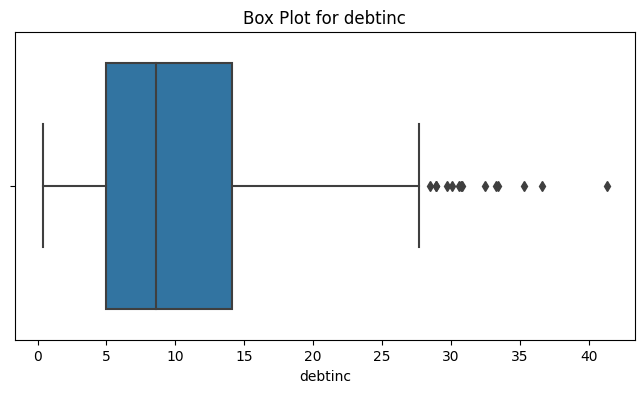

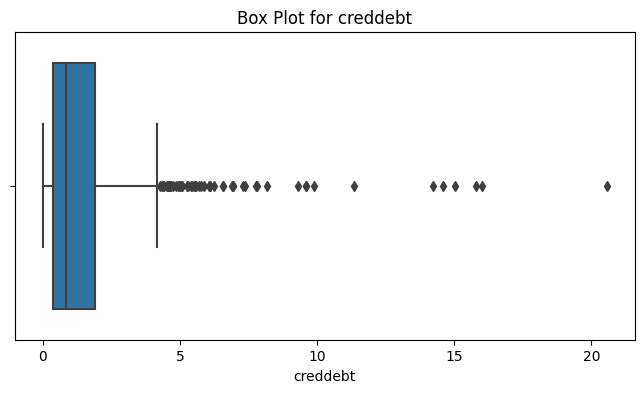

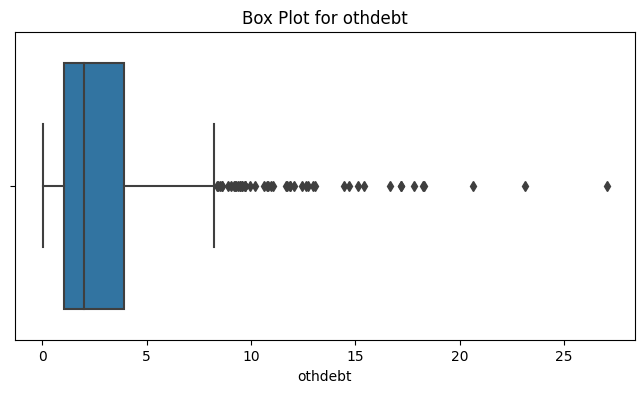

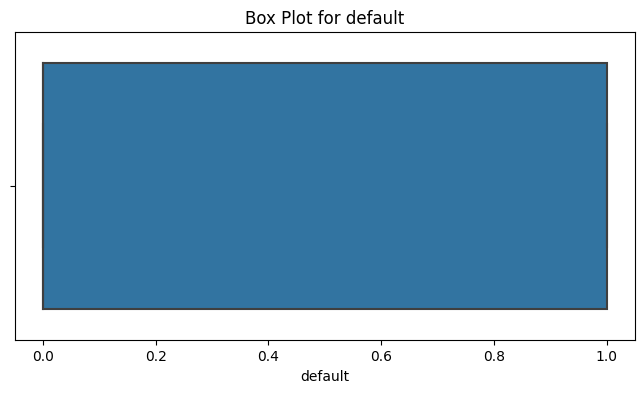

In [13]:
# Select the column(s) to visualize outliers
columns = df.columns.tolist()

# Create box plots for each selected column
for column in columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Box Plot for {column}')
    plt.show()

We observe that most of the columns have outliers, especially the income, debtinc, creddebt, and othdebt columns.

The outliers can be removed using the z-score or inter-quartile range. But for this scenario, each row represent's a unique individual with unique features so it is beneficial to preserve all information regardless of their distribution amongst others. Therefore, we leave the outliers

# EXPLORATORY DATA ANALYSIS (EDA)

Now that we've cleaned the data, let's do some analysis to address our original question: predicting whether a customer will be a default or a successful loan payer. 

In [14]:
#let's describe the dataset 
df.describe()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
count,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,34.860000,1.722857,8.388571,8.278571,45.601429,10.260571,1.553553,3.058209,0.261429
std,7.997342,0.928206,6.658039,6.824877,36.814226,6.827234,2.117197,3.287555,0.439727
min,20.000000,1.000000,0.000000,0.000000,14.000000,0.400000,0.011696,0.045584,0.000000
25%,29.000000,1.000000,3.000000,3.000000,24.000000,5.000000,0.369059,1.044178,0.000000
50%,34.000000,1.000000,7.000000,7.000000,34.000000,8.600000,0.854869,1.987567,0.000000
75%,40.000000,2.000000,12.000000,12.000000,55.000000,14.125000,1.901955,3.923065,1.000000
max,56.000000,5.000000,31.000000,34.000000,446.000000,41.300000,20.561310,27.033600,1.000000


Lets analyze the distribution of all the features, since they are all numerical

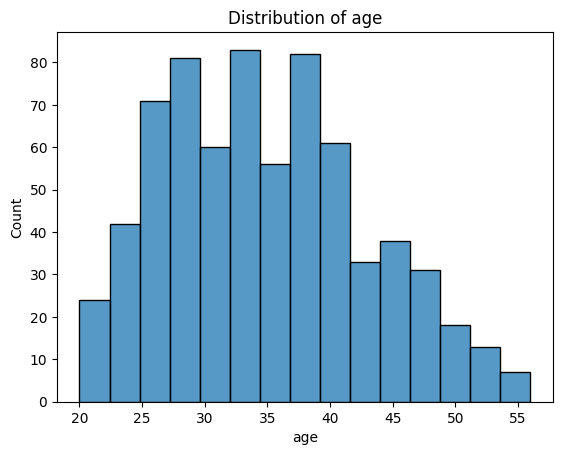

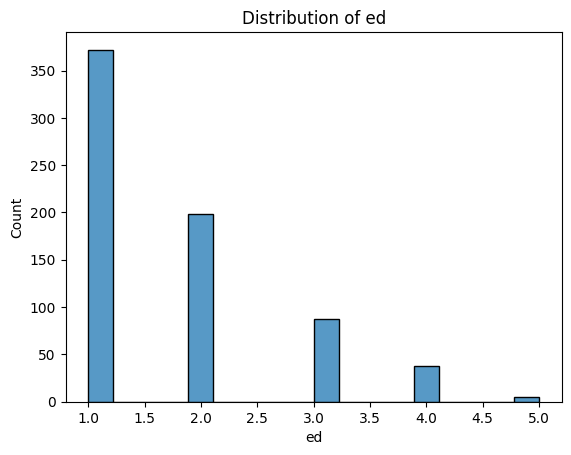

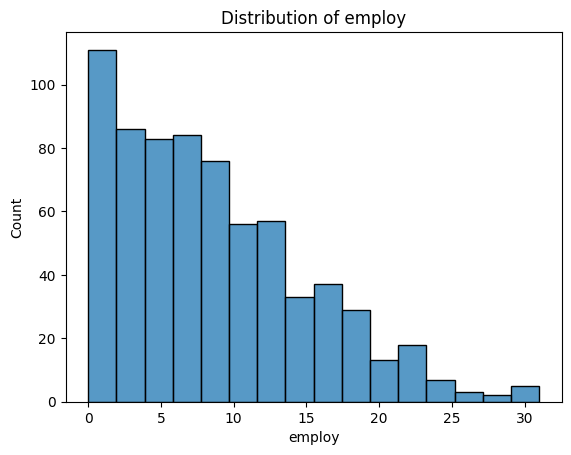

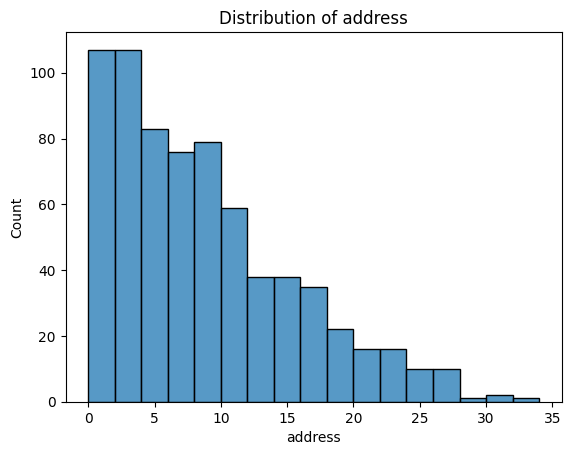

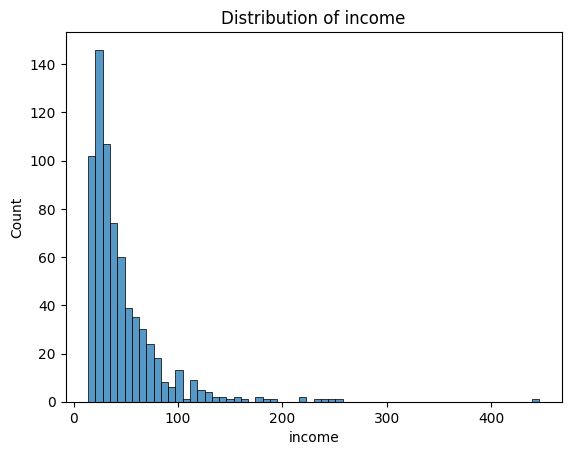

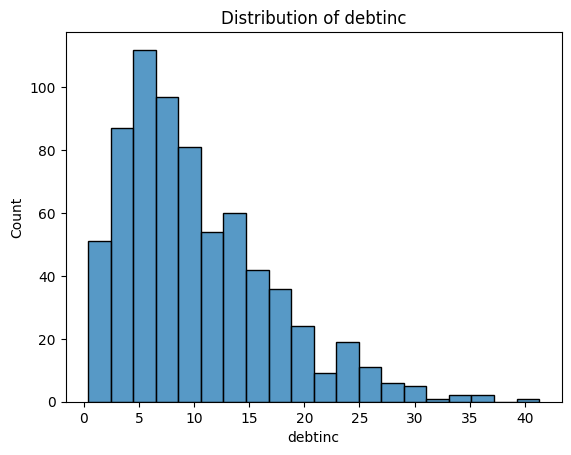

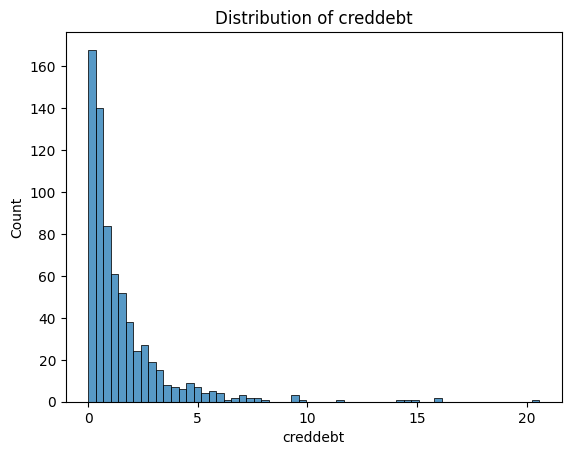

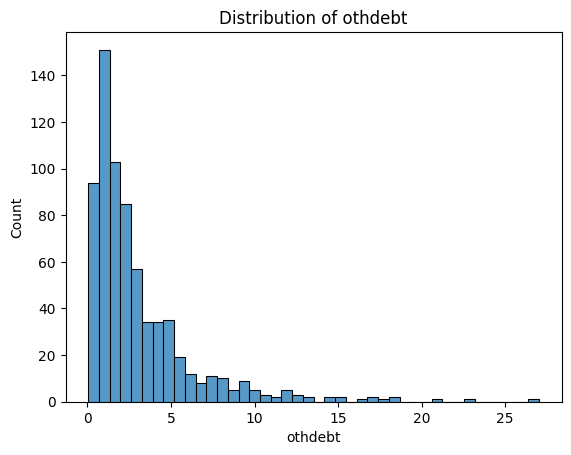

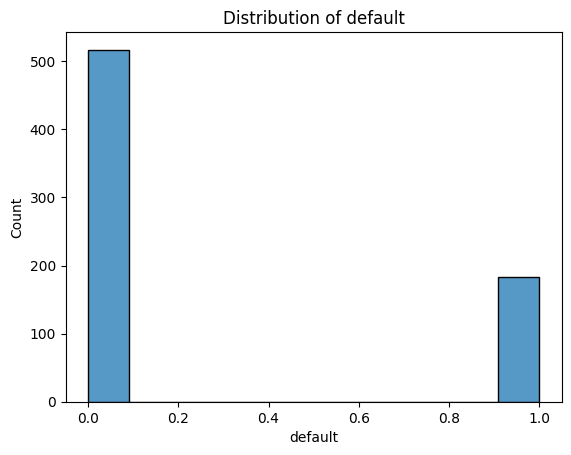

In [15]:
# Plot the distribution of all columns
for column in df.columns.to_list():
    sns.histplot(df[column])
    plt.title(f"Distribution of {column}")
    plt.show()

From our analysis, we can see that our data contains data from individuals in a wide age range. The age of loan expend applicant starts at 20 years old to 55 years, with bi-modal between 30 to 40 year of age.

And the rest of the features follow a similar right-skewed distribution

For futher analysis, we can group the age into brackets

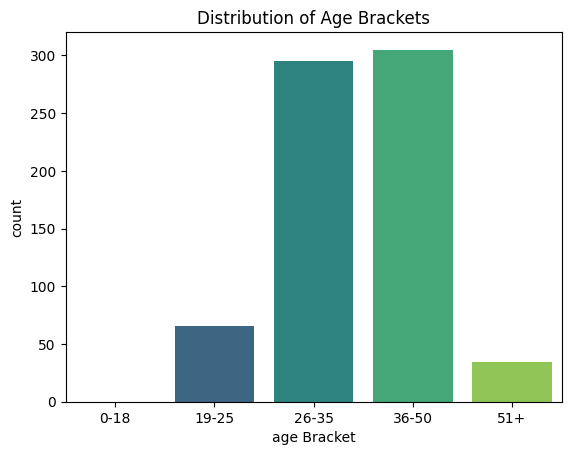

In [16]:
# Define the age brackets
age_bins = [0, 18, 25, 35, 50, 100]
age_labels = ['0-18', '19-25', '26-35', '36-50', '51+'] # Labels for the age brackets

# Create a new column with age brackets
df['age Bracket'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Plot the distribution of age brackets
sns.countplot(data=df, x='age Bracket', palette='viridis')
plt.xlabel('age Bracket')
plt.ylabel('count')
plt.title('Distribution of Age Brackets')
plt.show()

# Drop column back
df = df.drop(columns=['age Bracket'])

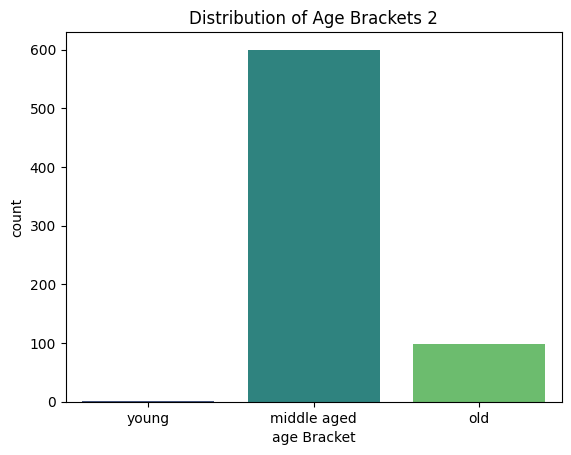

In [17]:
# Define the age brackets
age_bins = [0, 21, 45, 100]
age_labels = ['young', 'middle aged', 'old'] # Labels for the age brackets

# Create a new column with age brackets
df['age Bracket'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)

# Plot the distribution of age brackets
sns.countplot(data=df, x='age Bracket', palette='viridis')
plt.xlabel('age Bracket')
plt.ylabel('count')
plt.title('Distribution of Age Brackets 2')
plt.show()

# Drop column back
df = df.drop(columns=['age Bracket'])

We see that most individuals fall within the middle aged bracket (i.e. 26-35 and 36-50)

Next let's check linear relationship between credit to debt ratio

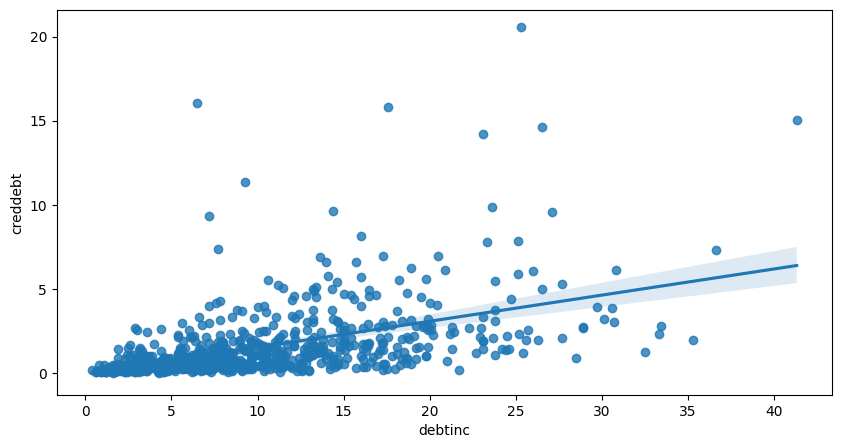

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
sns.regplot(x="debtinc", y="creddebt", data=df, ax=ax)
plt.show()

We can see a strong positive linear relationsip between the credit and debit ratio

Next we can check for the linear relationship between age and income

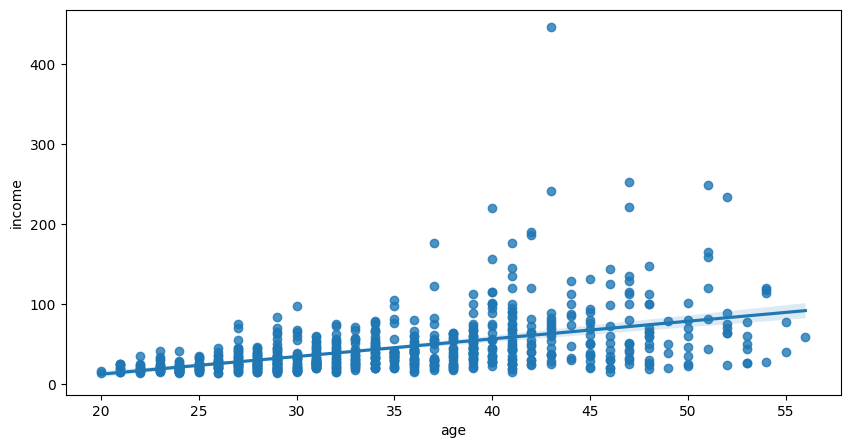

In [19]:
fig,ax = plt.subplots(figsize=(10,5))

sns.regplot(x="age", y="income", data=df, ax=ax)
plt.show()

We can see that age and income a well correlated, and showing uptrend movement, the income tend to rise at 35 years of age and begins to decline at 55.

This might indicate that the individual's income increase with work experience lenght and drop close to the retirment as the individual will be living off on pension or savings 

Checking relationship between age and debt to income ration 

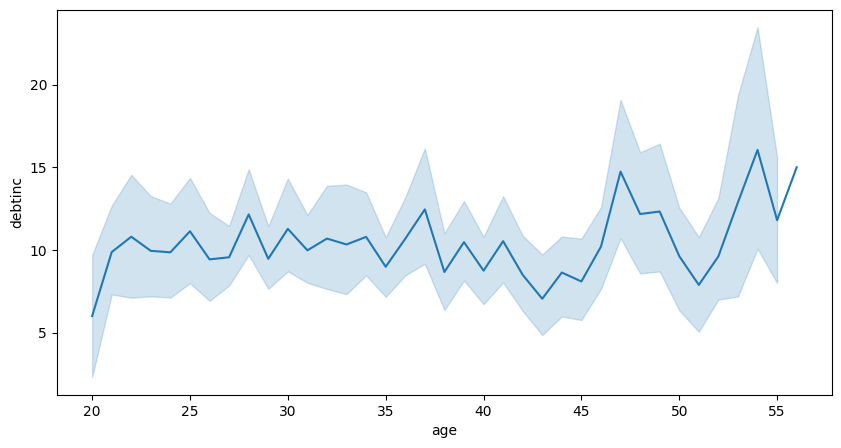

In [20]:
fig, ax = plt.subplots(figsize=(10,5))

sns.lineplot(x="age", y="debtinc", data=df, ax=ax)
plt.show()

debt-to-income ratio (DTI) compares how much an individual owes to their net income. We can notice that from 45 to 55 years of age the DTI is really high, this can be due to high percentage of your gross monthly income (before taxes) that goes towards payments for rent, mortgage, credit cards, or other debt. due the responsabilities 

We can also check age and debt-to-credit ratio

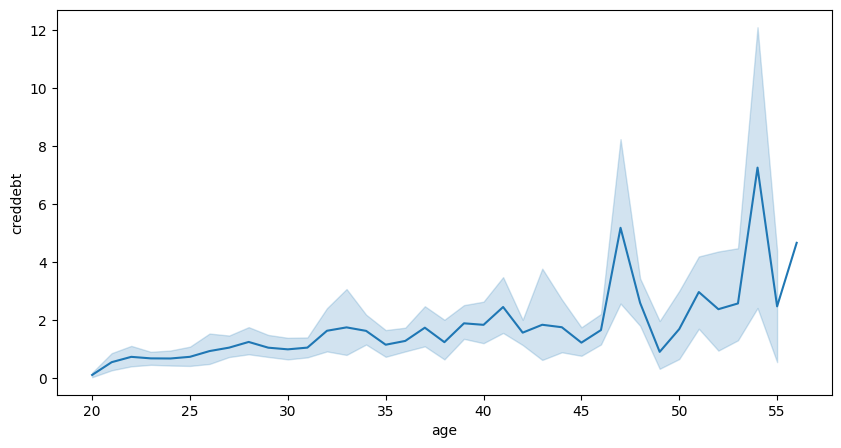

In [21]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='age',y='creddebt', data=df,ax=ax)

plt.show()

credit utilization rate or debt-to-credit rate, represents the amount of revolving credit an individual use divided by the total amount of credit available to them. Revolving credit accounts include things like credit cards and lines of credit.
we can see some category of age 45 to 55 have high credit utilization this might be explained to high responsabilities 

We can also check the employment status of individuals

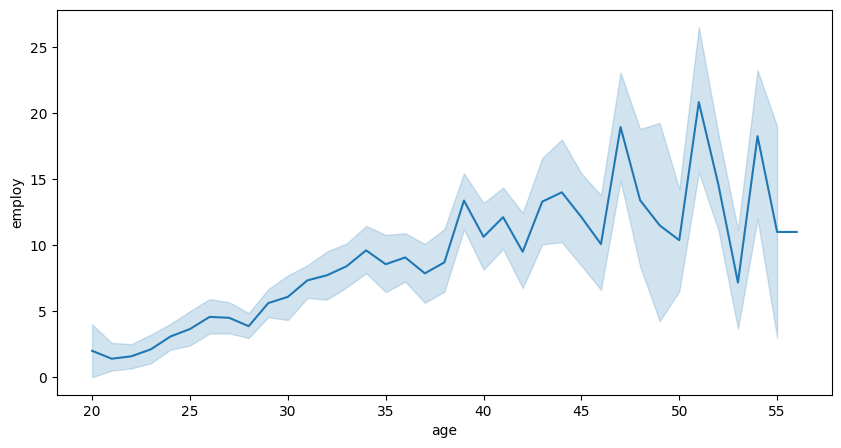

In [22]:
fig,ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='age',y='employ', data=df,ax=ax)

plt.show()

the data shows more individuals in young age are unemployed

Lastly we can check the distribution of the target varaible again

In [23]:
df['default'].value_counts(normalize=True)

0.0    0.738571
1.0    0.261429
Name: default, dtype: float64

The target variable distribution shows 26% of ones and 78% of zeros in the dataset. One means the customer has defualted in the past, and 0 represents the customer never defaulted.

# MODELLING

After cleaning our data and performing some EDA, we then proceed to build a model which helps predict the likely hood that an individual will default on a credit

We split our data into train, test, and validation sets. We will be using Stratified random sampling. This method selects data samples at random within specific parameters. It ensures the data is correctly distributed in training and test sets.

In [14]:
# import Train Test Split
from sklearn.model_selection import train_test_split

# Instantiate X and y
X = df.drop('default', axis=1)
y = df['default']

# Remainder Test Split
X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.30, stratify = y, random_state=42)

# Validation Train Split
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=0.30, stratify = y_rem, random_state=42)



# Print info on how the data has been split
print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

The remainder set has 490 data points.
The test set has 210 data points.


Since our data contains floats and integers of far apart magnitude, we will use StandardScaler to scale each feature/variable to unit variance.

In [15]:
# instantiate, fit, transform standard scaler
sc = StandardScaler()
sc.fit(X_train)
X_train_sc = sc.transform(X_train)

X_val_sc = sc.transform(X_val)

# Logistic Regression

In [16]:
# Instantiate and fit Logistic Regression model 
logreg = LogisticRegression(solver='lbfgs',penalty='none',max_iter=1000)
logreg.fit(X_train_sc, y_train)

# y-predict using validation data
y_pred = logreg.predict(X_val_sc)

# Model eveluation 
print(f'The train accuracy is: {logreg.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {logreg.score(X_val_sc, y_val)}')

The train accuracy is: 0.8046647230320699
The Validation accuracy is: 0.8503401360544217


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Our accuracy is relatively standard (Train is 80% and Validation is 85%)

Thus, there is no obvious sign that our model is s overfitting.

Our data is also slightly imbalaned, although this is not sever, we will utilize some additional model evaluation metrics to properly understand our model's performance

Evaluation

Classification Report: we have choice this metric because is a summary of the performance metrics for a classification model. It includes the precision, recall, F1-score, and support for each class. The support is the number of observations in each class. The classification report is useful for comparing the performance of different models or for evaluating the performance of a single model on different datasets.

In [17]:
# classification report
print(classification_report(y_val, logreg.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.84      0.98      0.91       109
         1.0       0.90      0.47      0.62        38

    accuracy                           0.85       147
   macro avg       0.87      0.73      0.76       147
weighted avg       0.86      0.85      0.83       147



the model predicted 47% of customers we will be defaulted at some point,  the precision score is 90% that means 62% client out of 47% will be definitly default (or permanantly) 

Accuracy   : 0.8503401360544217


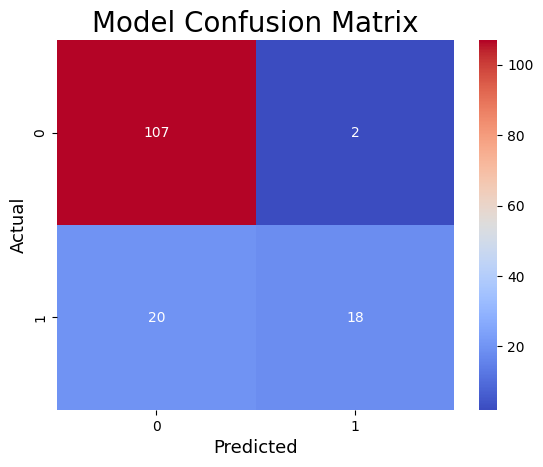

In [18]:
# checking the confusion matrick 
cm = confusion_matrix(y_val, logreg.predict(X_val_sc))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Model Confusion Matrix',fontsize=20);

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy   :", accuracy)

# Random Forest

our next model will be Random forest and will try to compare the accuracy of this model to the previous one


In [19]:
from sklearn.linear_model import LogisticRegression

# Instantiate and fit Logistic Regression
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {rfc.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {rfc.score(X_val_sc, y_val)}')

The train accuracy is: 1.0
The Validation accuracy is: 0.8435374149659864


The train set has a decent accuracy of 100%, while the validation set is 84%. But that metric alone is not enough to tell us how well the model performed, ideally we should have a closer look at other useful metrics, most of which can be found in the classification report

In [21]:
# classification report
print(classification_report(y_val, rfc.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90       109
         1.0       0.86      0.47      0.61        38

    accuracy                           0.84       147
   macro avg       0.85      0.72      0.76       147
weighted avg       0.85      0.84      0.83       147



although the result of the confusion matric contradicted the the model training result maybe because of overtfitting, we cannot notice an improvement on loan default customer that dropped 4% in precesion 

We will try to improve our result with a cross validation

In [24]:
rfc2 = cross_val_score(estimator=rfc, X=X_train_sc, y=y_train, cv=10)

# Evaluate the model
rfc2.mean()

0.7788235294117647

with a 10 fold cross validation run we can see that our model provides an accuracy of 77%, no observed improvement 

# Support Vector Machine (SVM)

 Support Vector Machine (SVM) is a supervised machine learning model for classifications and regressions. Since SVM is commonly used for classification, we will try to predict our project here as well. 

In [25]:
# Instantiate and fit SVC on scaled data
svc = SVC()

svc.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {svc.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {svc.score(X_val_sc, y_val)}')

The train accuracy is: 0.8192419825072886
The Validation accuracy is: 0.8163265306122449


The SVC provided an accuracy of 82% accuracy, which is decent. Let's proceed to evaluate the model with a classification report.

In [26]:
# classification report
print(classification_report(y_val, svc.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89       109
         1.0       0.92      0.32      0.47        38

    accuracy                           0.82       147
   macro avg       0.86      0.65      0.68       147
weighted avg       0.84      0.82      0.78       147



We notice a slight increase in our recall and precision score.

We can furthur improve on our results by implementing hyperparameter tunning

using GridSearchCV hyperparameter tunning

In [30]:
# define hyperparameters to tune
svc_model = GridSearchCV(svc,{
    'C':[0.1,0.2,0.4,0.8,1.2,1.8,4.0,7.0],
    'gamma':[0.1,0.4,0.8,1.0,2.0,3.0],
    'kernel':['rbf','linear']
},scoring='accuracy',cv=10)

In [31]:
svc_model.fit(X_train_sc, y_train)
svc_model.best_params_

{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}

we have our best parameters and now will run the svc again to see how it might improve hour result 

In [32]:
svc_model2 = SVC(C=0.1, gamma=0.1, kernel='linear')
svc_model2.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {svc_model2.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {svc_model2.score(X_val_sc, y_val)}')

The train accuracy is: 0.7959183673469388
The Validation accuracy is: 0.8027210884353742


The grindsearch hyperparamater tunning had almost no effect on our accuracy. If anything, it decreased both metrics by a little

In [34]:
# classification report
print(classification_report(y_val, svc_model2.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.79      0.99      0.88       109
         1.0       0.91      0.26      0.41        38

    accuracy                           0.80       147
   macro avg       0.85      0.63      0.64       147
weighted avg       0.82      0.80      0.76       147



Accuracy   : 0.8503401360544217


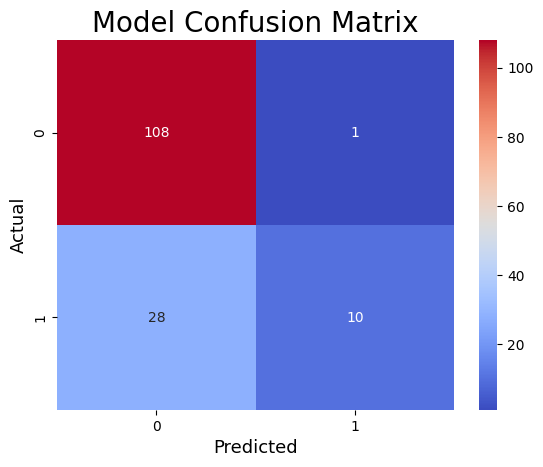

In [35]:
# checking the confusion matrick for the best model 
cm = confusion_matrix(y_val, svc_model2.predict(X_val_sc))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='g')
plt.xlabel('Predicted',fontsize=13)
plt.ylabel('Actual',fontsize=13)
plt.title('Model Confusion Matrix',fontsize=20);

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy   :", accuracy)

we can see that our confusion matric provide an accuracy of 85% this which is close to our precision

# K-Nearest Neighbors(KNN)

we're still in the process of finding the best model and we will try Knn now: K-Nearest Neighbors, commonly known as KNN. It is a classifier method where the learning is based on “how similar” is a data (a vector) from other.

It is important to note that the k-NN algorithm is a lazy learner, meaning it does not learn a model to make predictions. Instead, it stores all the training data and uses it to make predictions when new data points are encountered.

In [37]:
# Fitting a  knn model 
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {knn_model.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {knn_model.score(X_val_sc, y_val)}')

The train accuracy is: 0.8746355685131195
The Validation accuracy is: 0.7482993197278912


we can see that our Knn model produce the accuracy in train set of 87% and 75% for the validation set accuracy, the number still decent but will look at classification refport.

In [38]:
# classification report
print(classification_report(y_val, knn_model.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       109
         1.0       0.52      0.42      0.46        38

    accuracy                           0.75       147
   macro avg       0.66      0.64      0.65       147
weighted avg       0.73      0.75      0.74       147



our knn model have 81% of precession and 86% of recall on paid loans while default loans are in order 52% for precession and 42% recall

next we're going to optimize our model by finding the best value of K and see if we can get the best resolt than this. 

In [39]:
# Define a range of k values to test
k_values = [1, 3, 5, 7, 9, 11, 13, 15]

# Train a KNN model for each value of k and evaluate the result
best_k = 1
best_accuracy = 0

for k in k_values:

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_sc, y_train)
    y_pred = knn.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f'k={k}: validation accuracy={accuracy}')

    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best value of k: {best_k} with validation accuracy of {best_accuracy}')

k=1: validation accuracy=0.2585034013605442
k=3: validation accuracy=0.7891156462585034
k=5: validation accuracy=0.7482993197278912
k=7: validation accuracy=0.7074829931972789
k=9: validation accuracy=0.7414965986394558
k=11: validation accuracy=0.7414965986394558
k=13: validation accuracy=0.7414965986394558
k=15: validation accuracy=0.7414965986394558
Best value of k: 3 with validation accuracy of 0.7891156462585034


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but KNeighborsClassifier 

Fitting our best Parameters 

we have now our best K that is 3 and will now rerun the new Knn and see

In [40]:
from sklearn.neighbors import KNeighborsClassifier
# Fitting a  knn model 
knn_model2 = KNeighborsClassifier(n_neighbors = 3)
knn_model2.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {knn_model2.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {knn_model2.score(X_val_sc, y_val)}')

The train accuracy is: 0.8746355685131195
The Validation accuracy is: 0.7482993197278912


There is no improvement in our accuracy score. Thus our initial model was already optimized

Next, digging into the classification report.

In [41]:
# classification report
print(classification_report(y_val, knn_model2.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.81      0.86      0.84       109
         1.0       0.52      0.42      0.46        38

    accuracy                           0.75       147
   macro avg       0.66      0.64      0.65       147
weighted avg       0.73      0.75      0.74       147



there is not any significant improvement in the models

# Decision Trees

our final model will be  Decision Trees, A Decision Tree follows a tree-like structure (hence the name) whereby a node represents a specific attribute, a branch represents a decision rule, and leaf nodes represent an outcome.



In [46]:
# Fitting a  knn model 
Dt_model = DecisionTreeClassifier(max_depth=10) 
Dt_model.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {Dt_model.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {Dt_model.score(X_val_sc, y_val)}')

The train accuracy is: 1.0
The Validation accuracy is: 0.7278911564625851


DT model provides 100% of accuracy on the train and 73% accuracy on the validation set. this the highest score noticed until now.

reviewing the classification report

In [47]:
# classification report
print(classification_report(y_val, Dt_model.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.82      0.81      0.81       109
         1.0       0.47      0.50      0.49        38

    accuracy                           0.73       147
   macro avg       0.65      0.65      0.65       147
weighted avg       0.73      0.73      0.73       147



we can see that our model performs a lot better for paid loans than defaulted individuals

DT models are known to overfit easily, which explains our high train accuracy and mid validation accuracy.

To resolve this issue, we will use hyperparameter optimization

Optimize Hyperparameters

In [48]:
# checking the best max depth 
max_depth_values = range(1, 20)

best_max_depth = 1
best_accuracy = 0

max_depth_dict = {}

for max_depth in max_depth_values:

    dt_model = DecisionTreeClassifier(max_depth=max_depth)

    dt_model.fit(X_train_sc, y_train)
    y_pred = dt_model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)

    print(f'max_depth={max_depth}: validation accuracy={accuracy}')

    max_depth_dict[max_depth] = accuracy

    if accuracy > best_accuracy:
        best_max_depth = max_depth
        best_accuracy = accuracy

print(f'Best value of max_depth: {best_max_depth} with validation accuracy of {best_accuracy}')

max_depth=1: validation accuracy=0.7414965986394558
max_depth=2: validation accuracy=0.7687074829931972
max_depth=3: validation accuracy=0.5782312925170068
max_depth=4: validation accuracy=0.6054421768707483
max_depth=5: validation accuracy=0.5986394557823129
max_depth=6: validation accuracy=0.5714285714285714
max_depth=7: validation accuracy=0.54421768707483
max_depth=8: validation accuracy=0.5782312925170068
max_depth=9: validation accuracy=0.54421768707483
max_depth=10: validation accuracy=0.5578231292517006
max_depth=11: validation accuracy=0.5782312925170068
max_depth=12: validation accuracy=0.5578231292517006
max_depth=13: validation accuracy=0.5782312925170068
max_depth=14: validation accuracy=0.5578231292517006
max_depth=15: validation accuracy=0.54421768707483
max_depth=16: validation accuracy=0.5782312925170068
max_depth=17: validation accuracy=0.5850340136054422
max_depth=18: validation accuracy=0.54421768707483
max_depth=19: validation accuracy=0.5918367346938775
Best value

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeC

In [52]:
max_depth_dict

{1: 0.7414965986394558,
 2: 0.7687074829931972,
 3: 0.5782312925170068,
 4: 0.6054421768707483,
 5: 0.5986394557823129,
 6: 0.5714285714285714,
 7: 0.54421768707483,
 8: 0.5782312925170068,
 9: 0.54421768707483,
 10: 0.5578231292517006,
 11: 0.5782312925170068,
 12: 0.5578231292517006,
 13: 0.5782312925170068,
 14: 0.5578231292517006,
 15: 0.54421768707483,
 16: 0.5782312925170068,
 17: 0.5850340136054422,
 18: 0.54421768707483,
 19: 0.5918367346938775}

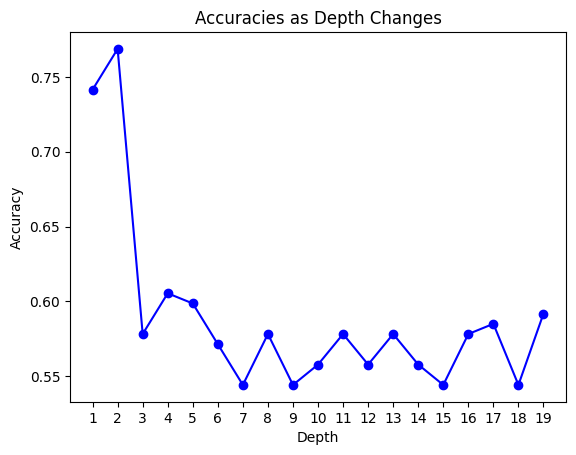

In [54]:
# Extract keys and values from the dictionary
keys = list(max_depth_dict.keys())
values = list(max_depth_dict.values())

# Plot the keys and values
plt.plot(keys, values, marker='o', linestyle='-', color='blue')

# Set labels and title
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.title('Accuracies as Depth Changes')

plt.xticks(keys)
# Show the plot
plt.show()

our best best depth is 2 and will now fit the model for the second time 

In [49]:
# Fitting a  knn model 
Dt_model2 = DecisionTreeClassifier(max_depth=2)
Dt_model2.fit(X_train_sc, y_train)

# Evaluate the model
print(f'The train accuracy is: {Dt_model2.score(X_train_sc, y_train)}')
print(f'The Validation accuracy is: {Dt_model2.score(X_val_sc, y_val)}')

The train accuracy is: 0.7638483965014577
The Validation accuracy is: 0.7891156462585034


the overfiting issues has been resolved and we can see closeness between the accuracy score of the train and validation set.

We will try to re-run our classification report 

In [50]:
# classification report
print(classification_report(y_val, Dt_model2.predict(X_val_sc)))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       109
         1.0       0.62      0.47      0.54        38

    accuracy                           0.79       147
   macro avg       0.73      0.69      0.70       147
weighted avg       0.78      0.79      0.78       147



our model still performs better for paid loans than defaulted loans, but the gap has been reduced

All models provided different results and can be used in different cases depending on what is to be priotized. For our final mode we select the decision tree model.

Testing  best model on test data

In [55]:
# transform remainder and test data standard scaler
X_test_sc = sc.transform(X_test)
X_rem_sc = sc.transform(X_rem)

Dt_model3 = DecisionTreeClassifier(max_depth=2)
Dt_model3.fit(X_rem_sc, y_rem)


# Evaluate the model
print(f'The train accuracy is: {Dt_model3.score(X_rem_sc, y_rem)}')
print(f'The Validation accuracy is: {Dt_model3.score(X_test_sc, y_test)}')

The train accuracy is: 0.7673469387755102
The Validation accuracy is: 0.7714285714285715


our score on useen data is slightly similar with seen data of our best model.
we will print the classification report for unseen that as well

Unsen data Evaluation

In [56]:
# classification report
print(classification_report(y_test, Dt_model3.predict(X_test_sc)))

              precision    recall  f1-score   support

         0.0       0.77      0.99      0.86       155
         1.0       0.82      0.16      0.27        55

    accuracy                           0.77       210
   macro avg       0.79      0.58      0.57       210
weighted avg       0.78      0.77      0.71       210



The recall and precision score are almost the same with our best seen data model.

Conclusion
we have tested the data on several model, such as Logistic Regression, Support Vector Machine,Decision Trees,Random Forest and K-Nearest Neighbors with and without the optimizer for each of them. from all of model tested, our optimized decision tree provide the best performance.

As  our goal  was to achieve the highest recall we could for default loans. Finally testing on the test data set, we were able to achieve:

Default Recall: 16%
Default Precision: 82%
Paid Recall: 99%
Paid Precision: 77%
Overall Accuracy: 77%

We have significantly increased performance our of model throughout the iterations. This is the final notebook and the end of our project.
Thank you.